Some profiles were acquired using simultaneous excitation, which was noted as leading to significant bleedthrough. However, the impact on profiles at 4-channel simultaneous excitation is minimal, thus suggesting that bleedthrough does not matter.

However, with an increase in bleedthrough comes a reduction in feature quality. For example, the RNA channel might have some signal from other channels, so it's no longer true RNA signal. So biological interpretation is limited.

Thus, profiling can overcome bleedthrough, but interpretation of the biological relevance of the features is severely limited. Features lose their meaning, 

In [244]:
import pandas as pd
import os
import numpy as np
import glob
import utilssphering

In [245]:
match_rep_df = pd.read_csv("/Users/ctromans/image-analysis/jump_scope/jump-scope-analysis/checkpoints/match_rep_df.csv")

/var/folders/rw/691cc6h16f9cfxlh9g6bpq400000gq/T/ipykernel_80469/2647377791.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["simultaneous-excitation"] = df_subset["simultaneous-excitation"].astype("Int64")


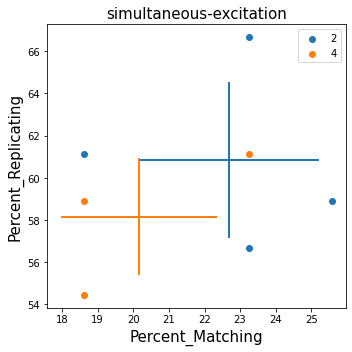

In [441]:
# A

group = "simultaneous-excitation"

df_subset = match_rep_df[
    (match_rep_df["sphering"] == True) &
    (~match_rep_df["Batch"].str.contains("siteSub")) 
    ]

df_subset["simultaneous-excitation"] = df_subset["simultaneous-excitation"].astype("Int64")

group_df = utilssphering.find_group_avg_df(df_subset, group)

fig, ax = plt.subplots(figsize=(5,5))

utilssphering.group_plot(
    df=group_df, 
    x="Mean_Percent_Matching", 
    y="Mean_Percent_Replicating",
    group=group,
    error_x="SD_Percent_Matching",
    error_y="SD_Percent_Replicating",
    fig=fig,
    ax_=ax,
    alpha=0.5
)
utilssphering.group_plot(
    df=df_subset,
    x="Percent_Matching", 
    y="Percent_Replicating",
    group=group,
    fig=fig,
    ax_=ax,
    legend=True
)
        
fig.savefig("(A)-rep-vs-match-simultaneous_excitation.png", dpi=300)

In [391]:
def search_correlations(metadata_df, profile_path):
    """

    """
    df_list = []
    # metadata_df = metadata_df[~metadata_df["Batch"].str.contains("siteSub")]
    df = metadata_df.copy()
    df = df[~df["Batch"].str.contains("siteSub")]
    for ind, row in df.iterrows():
        df_path = os.path.join(profile_path, row["Batch"], row["Assay_Plate_Barcode"], f"{row['Assay_Plate_Barcode']}.csv.gz")
        load_df = pd.read_csv(df_path)
        cols = [i for i in load_df.columns if "Correlation" in i]
        # Mask data so we only gather the correlation features for aggregation
        load_df = load_df[cols]
        # For the masked dataset (which represents one plate), aggregate all well values. 384 rows will be aggregated into one.
        load_df = load_df.agg(np.mean).to_frame().transpose()
        # Since the DF was masked by [cols], add back in the Batch, Assay_Plate_Barcode and channel_names, based on the row info
        load_df["Batch"], load_df["Assay_Plate_Barcode"], load_df["channel_names"], load_df["simultaneous-excitation"] = [row["Batch"], row["Assay_Plate_Barcode"], row["channel_names"], row["simultaneous-excitation"]]
        df_list.append(load_df)
    out_df = pd.concat(df_list)
    return out_df

corr_df = search_correlations(match_rep_df, "../../../../jump-scope/profiles/")


In [444]:
cols = [i for i in corr_df.columns if "Cells_Correlation_Correlation" in i and "BrightField" not in i]

cols.append("simultaneous-excitation")

df = corr_df[corr_df["Batch"].str.contains("Yokogawa_US")][cols].dropna(axis=1, how="all")

df = df.groupby("simultaneous-excitation").agg(np.mean).T.reset_index()

df.rename(columns={"index": "Simultaneous Excitation", 2: "2", 4: "4"}, inplace=True)

df["2"] = df["2"].astype(float).round(5)
df["4"] = df["4"].astype(float).round(5)

df

df.to_csv("(B)-simultaneous_excitation_bleedthrough.csv", index=False)

# "Why is there no Cells_Correlation_Correlation_DNA_AGP?" - note the AGP
# This is because this has already been calculated as
# Cells_Correlation_Correlation_AGP_DNA. Correlations are the same either way

In [390]:
## Alternative to the above which finds profiles with the same channel combination
## and looks at their bleedthrough. This is therefore termed 1.0 simultaneous excitation

## However, the fundamental error with this is that the microscopes are different, with different
## filter sets, so interpret with caution

cols = [i for i in corr_df.columns if "Cells_Correlation_Correlation" in i and "BrightField" not in i]

cols.extend(["simultaneous-excitation", "channel_names"])

df = corr_df[corr_df["channel_names"].str.contains("AGP, BrightField, DNA, ER, Mito, RNA|AGP, DNA, ER, Mito, RNA")][cols].dropna(axis=1, how="all")


df["simultaneous-excitation"] = np.where(df["simultaneous-excitation"].isnull(), 1, df["simultaneous-excitation"])

# Some feature names have used "WGPhalloidin" instead of AGP, rectify this
# df.columns = df.columns.str.replace("WGPhalloidin", "AGP")

df
# df
df.groupby("simultaneous-excitation").agg(np.mean).T

simultaneous-excitation,1.0,2.0,4.0
Cells_Correlation_Correlation_DNA_ER,0.181615,0.161078,0.586073
Cells_Correlation_Correlation_DNA_Mito,0.230552,0.294642,0.283360
Cells_Correlation_Correlation_DNA_RNA,0.240139,0.213621,0.238256
Cells_Correlation_Correlation_ER_Mito,0.787388,0.767224,0.635926
Cells_Correlation_Correlation_ER_RNA,0.904203,0.905272,0.662252
Cells_Correlation_Correlation_Mito_RNA,0.733063,0.763210,0.681534
Cells_Correlation_Correlation_AGP_DNA,0.394227,0.412343,0.497437
Cells_Correlation_Correlation_AGP_ER,0.486427,0.741505,0.672297
Cells_Correlation_Correlation_AGP_Mito,0.485078,0.675921,0.584100
Cells_Correlation_Correlation_DNA_WGPhalloidin,0.488014,NaN,NaN
